# Basic imports
---

In [32]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shutil
import glob
import random
%matplotlib inline

import urllib.request
from PIL import Image
import io

import cv2

import torch
import torch.nn.functional as F
from torch import optim, nn, utils, Tensor
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data.dataset import random_split
from torchvision.datasets import ImageFolder

import torchvision
from torchvision.datasets import MNIST, CIFAR10

from torchvision import transforms
from torchvision.transforms import Compose, ToTensor, Resize, Normalize
from torchvision.models import resnet18, ResNet18_Weights

import torchmetrics

import lightning as L
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.loggers import CSVLogger

import kagglehub
from kagglehub import KaggleDatasetAdapter

# Download and process the data set
---

In [33]:
# Load dataset from local data_set folder
dataset_path = "data_set"

print("Loading dataset from:", dataset_path)
print("\nDataset contents:")
for root, dirs, files in os.walk(dataset_path):
    level = root.replace(dataset_path, '').count(os.sep)
    indent = ' ' * 2 * level
    print(f'{indent}{os.path.basename(root)}/')
    subindent = ' ' * 2 * (level + 1)
    for file in files:
        print(f'{subindent}{file}')

# Load the CSV file
df = pd.read_csv(os.path.join(dataset_path, "receipts.csv"))
print(f"\n✓ Loaded receipts.csv with {len(df)} records")
print("\nFirst 5 records:")
print(df.head())

Loading dataset from: data_set

Dataset contents:
data_set/
  annotations.xml
  receipts.csv
  images/
    8.jpg
    9.jpg
    14.jpg
    15.jpg
    17.jpg
    16.jpg
    12.jpg
    13.jpg
    11.jpg
    10.jpg
    18.jpg
    19.jpg
    4.jpg
    5.jpg
    7.jpg
    6.JPG
    2.jpg
    3.jpg
    1.jpg
    0.jpg
  boxes/
    8.png
    9.png
    14.png
    15.png
    17.png
    16.png
    12.png
    13.png
    11.png
    10.png
    18.png
    19.png
    4.png
    5.png
    7.png
    6.png
    2.png
    3.png
    1.png
    0.png

✓ Loaded receipts.csv with 20 records

First 5 records:
   image_id    image_name
0         0  images/0.jpg
1         1  images/1.jpg
2         2  images/2.jpg
3         3  images/3.jpg
4         4  images/4.jpg


## Show an image from the data set

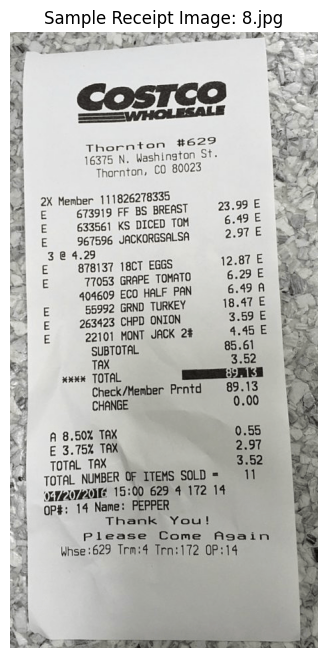

Image shape: (929, 463, 3)
Total images in dataset: 19


In [34]:
# Display a sample image from the dataset
images_path = os.path.join(dataset_path, "images")
image_files = [f for f in os.listdir(images_path) if f.endswith(('.jpg', '.png', '.jpeg'))]

if image_files:
    # Load and display the first image
    sample_image_path = os.path.join(images_path, image_files[0])
    image = cv2.imread(sample_image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for proper display
    
    plt.figure(figsize=(10, 8))
    plt.imshow(image)
    plt.title(f'Sample Receipt Image: {image_files[0]}')
    plt.axis('off')
    plt.show()
    
    print(f"Image shape: {image.shape}")
    print(f"Total images in dataset: {len(image_files)}")
else:
    print("No images found in the images folder.")

## Separates the data into different folders

In [35]:
# Split the dataset into train and test directories
# Split ratio: 80% training, 20% testing

original_images_path = os.path.join(dataset_path, 'images')
split_base_path = os.path.join(dataset_path, 'split')

# Check if split already exists
if os.path.exists(split_base_path):
    print(f"✓ Split directory already exists at: {split_base_path}")
    print("Skipping data split creation.")
else:
    print("Creating train/test split...")
    
    # Create main train and test directories
    train_path = os.path.join(split_base_path, 'train')
    test_path = os.path.join(split_base_path, 'test')
    os.makedirs(train_path, exist_ok=True)
    os.makedirs(test_path, exist_ok=True)
    
    print(f"Created directories: {train_path} and {test_path}")
    
    # Get all image files (case-insensitive)
    all_files = os.listdir(original_images_path)
    image_files = [f for f in all_files 
                   if f.lower().endswith(('.jpg', '.png', '.jpeg', '.bmp', '.tiff', '.tif', '.gif'))]
    
    # Debug: show all files and filtered images
    print(f"\nTotal files in images folder: {len(all_files)}")
    print(f"Image files found: {len(image_files)}")
    if len(all_files) != len(image_files):
        non_images = [f for f in all_files if f not in image_files]
        print(f"Non-image files skipped: {non_images}")
    
    # Shuffle images for random split
    random.seed(42)
    random.shuffle(image_files)
    
    # Calculate split index
    split_idx = int(len(image_files) * 0.8)
    train_files = image_files[:split_idx]
    test_files = image_files[split_idx:]
    
    # Copy files to train directory
    print(f"\nCopying {len(train_files)} images to train folder...")
    for img_file in train_files:
        src = os.path.join(original_images_path, img_file)
        dst = os.path.join(train_path, img_file)
        shutil.copy2(src, dst)
    
    # Copy files to test directory
    print(f"Copying {len(test_files)} images to test folder...")
    for img_file in test_files:
        src = os.path.join(original_images_path, img_file)
        dst = os.path.join(test_path, img_file)
        shutil.copy2(src, dst)
    
    print(f"\n✓ Data split completed successfully!")
    print(f"  - Training images: {len(train_files)} ({len(train_files)/len(image_files)*100:.1f}%)")
    print(f"  - Testing images: {len(test_files)} ({len(test_files)/len(image_files)*100:.1f}%)")
    print(f"  - Total images: {len(image_files)}")

# Verify the split
train_count = len(os.listdir(os.path.join(split_base_path, 'train')))
test_count = len(os.listdir(os.path.join(split_base_path, 'test')))
print(f"\nFinal split verification:")
print(f"  - Train folder: {train_count} images")
print(f"  - Test folder: {test_count} images")

Creating train/test split...
Created directories: data_set/split/train and data_set/split/test

Total files in images folder: 20
Image files found: 20

Copying 16 images to train folder...
Copying 4 images to test folder...

✓ Data split completed successfully!
  - Training images: 16 (80.0%)
  - Testing images: 4 (20.0%)
  - Total images: 20

Final split verification:
  - Train folder: 16 images
  - Test folder: 4 images
